In [2]:
#OVO JE KOD ZA COLAB, OVDE JE SAMO DA SE VIDI STA JE RADJENO
import torch
from google.colab import drive

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


In [3]:
import os

DATA_DIR = "/content/PlantVillage"

if not os.path.exists(DATA_DIR):
    print("Copying dataset...")
    !cp -r "/content/drive/MyDrive/PlantVillageDataset/Biljke/PlantVillage" "/content/PlantVillage"
    print("Copy finished.")
else:
    print("Dataset already exists. Skipping copy.")

Copying dataset...
Copy finished.


In [4]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

print("Total images:", len(dataset))
print("Classes:", len(dataset.classes))

Total images: 20638
Classes: 15


In [25]:
total_size = len(dataset)

train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [26]:
num_classes = len(dataset.classes)

model = models.efficientnet_b0(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Novi klasifikator
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    num_classes
)

model = model.to(device)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=2,
    factor=0.5
)

In [28]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, epochs=5):

    for epoch in range(epochs):

        model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()

        train_acc = 100 * train_correct / train_total

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}: Train {train_acc:.2f}% | Val {val_acc:.2f}%")

        if scheduler:
            scheduler.step(val_acc)

In [29]:
print("STAGE 1 – Training classifier")

train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=10)

STAGE 1 – Training classifier
Epoch 1: Train 72.94% | Val 86.43%
Epoch 2: Train 87.23% | Val 90.37%
Epoch 3: Train 88.94% | Val 91.79%
Epoch 4: Train 90.75% | Val 92.57%
Epoch 5: Train 91.25% | Val 93.28%
Epoch 6: Train 91.61% | Val 93.31%
Epoch 7: Train 92.29% | Val 93.38%
Epoch 8: Train 92.45% | Val 93.76%
Epoch 9: Train 92.43% | Val 93.57%
Epoch 10: Train 92.54% | Val 94.25%


In [30]:
# Odledjivanje poslednjeg bloka EfficientNet-a
for param in model.features[-1].parameters():
    param.requires_grad = True

In [31]:
optimizer = optim.Adam([
    {"params": model.features[-1].parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4},
])

In [32]:
print("STAGE 2 – Fine tuning")

train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=5)

STAGE 2 – Fine tuning
Epoch 1: Train 92.99% | Val 94.02%
Epoch 2: Train 93.24% | Val 94.35%
Epoch 3: Train 93.56% | Val 94.54%
Epoch 4: Train 93.55% | Val 94.80%
Epoch 5: Train 93.82% | Val 94.31%


In [33]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [34]:
accuracy = (all_preds == all_labels).mean() * 100
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Test Accuracy:", accuracy)
print("Test F1-score:", f1)

Test Accuracy: 94.34937035841136
Test F1-score: 0.9431883023679174


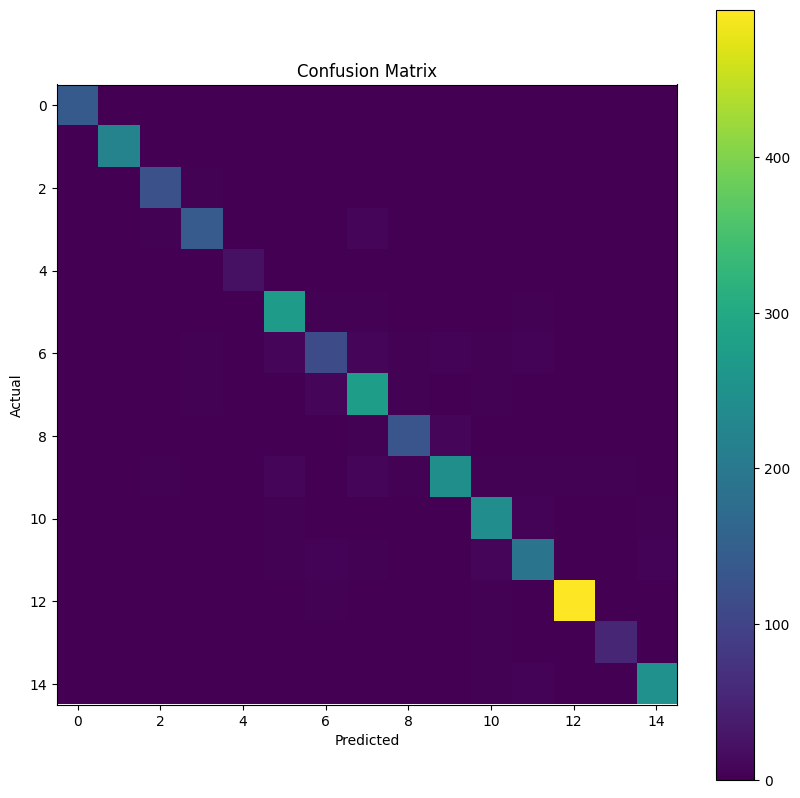

In [35]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [36]:
torch.save(model.state_dict(), "/content/drive/MyDrive/efficientnet_b0_plantvillage2.pth")

import json
with open("/content/drive/MyDrive/class_to_idx2.json", "w") as f:
    json.dump(dataset.class_to_idx, f)

In [37]:
import shutil

TEST_DIR = "/content/drive/MyDrive/PlantVillage_test2"

os.makedirs(TEST_DIR, exist_ok=True)

for idx in test_dataset.indices:
    img_path, label = dataset.samples[idx]
    class_name = dataset.classes[label]

    class_dir = os.path.join(TEST_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)

    shutil.copy(img_path, class_dir)

print("Test images saved to Drive")

Test images saved to Drive ✔
